<a href="https://colab.research.google.com/github/AsifAlFaisal/field-boundary-detection-unet/blob/master/Field_Boundary_Detection_Using_UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Author:** ©*Asif Al Faisal*

**Email:** asif.faisal.eee@gmail.com

**Organization:** CIMMYT

In [0]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

In [0]:
!pip install tensorflow==2.0

In [0]:
from __future__ import absolute_import, print_function
import tensorflow as tf
import numpy as np
import os, sys
import gdal
import IPython.display as display
from PIL import Image
import matplotlib.pyplot as plt
import pathlib
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img 
from sklearn.model_selection import train_test_split

import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization, Conv2DTranspose, Dropout, Concatenate
import re

In [0]:
tf.__version__

'2.0.0'

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load using keras.preprocessing

In [0]:
data_dir = "/content/drive/My Drive/Colab\ Notebooks/CIMMYT/Field/rgb_data"

In [0]:
photos, labels = list(), list()

# enumerate files in the directory
list_tr = os.listdir("/content/drive/My Drive/Colab Notebooks/CIMMYT/Field/rgb_data/train")
list_tr = sorted(list_tr)
list_tr_lb = os.listdir("/content/drive/My Drive/Colab Notebooks/CIMMYT/Field/rgb_data/train_label")
list_tr_lb = sorted(list_tr_lb)
for i in range(len(list_tr)):
  os.chdir("/content/drive/My Drive/Colab Notebooks/CIMMYT/Field/rgb_data/train")
  photo = load_img(list_tr[i], target_size=(192,192))
  #print("file {}".format(list_tr[i]))
  # covert to numpy array  
  photo = img_to_array(photo, dtype='uint8')
  
  
  # get labels
  os.chdir("/content/drive/My Drive/Colab Notebooks/CIMMYT/Field/rgb_data/train_label")
  label = load_img(list_tr_lb[i], target_size=(192,192))
  #print("Label {}".format(list_tr_lb[i]))
  label = img_to_array(label, dtype='uint8')
  
  ## store
  photos.append(photo)
  labels.append(label)

X = np.asarray(photos, dtype='uint8')
y = np.asarray(labels, dtype='uint8')
os.chdir("/content/drive/My Drive/Colab Notebooks/CIMMYT/Field/rgb_data")
np.savez_compressed('field_arr.npz',X, y)
print("Done!!")

Done!!


In [0]:
os.chdir("/content/drive/My Drive/Colab Notebooks/CIMMYT/Field/rgb_data")
data = np.load('field_arr.npz')
X, y = data['arr_0'], data['arr_1']

trainX, validX, trainY, validY = train_test_split(X, y, test_size=0.3, random_state=1)

In [0]:
print(trainX.shape, trainY.shape, validX.shape, validY.shape)

(82, 192, 192, 3) (82, 192, 192, 3) (36, 192, 192, 3) (36, 192, 192, 3)


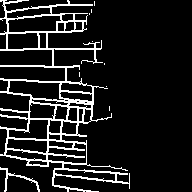

In [0]:
array_to_img(trainY[1])

In [0]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0, 
    horizontal_flip=True, 
    vertical_flip=True, 
    rotation_range=90, 
    shear_range=45.0,
    channel_shift_range = 150.0,
    brightness_range = (0.1, 0.9)).flow(trainX, trainY, batch_size = 4)

In [0]:
valid_datagen = ImageDataGenerator(rescale=1.0/255.0).flow(validX, validY, batch_size = 4)

In [0]:
!pip install -q git+https://github.com/tensorflow/examples.git

from tensorflow_examples.models.pix2pix import pix2pix

base_model = tf.keras.applications.MobileNetV2(input_shape=[192, 192, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

def unet_model(output_channels):

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same', activation='softmax')  #64x64 -> 128x128

  inputs = tf.keras.layers.Input(shape=[192, 192, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [0]:
model = unet_model(3)
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])

In [0]:
results = model.fit_generator(train_datagen, epochs=50, 
                          steps_per_epoch = len(train_datagen),
                          validation_data=valid_datagen, 
                          validation_steps=len(valid_datagen))

In [0]:
def load_image(filename):
  img = load_img(filename, target_size = (192,192))
  
  img = img_to_array(img)
  
  img = img.reshape(1, 192, 192, 3)
  
  img = img.astype('float32')
  
  img = img - [123.68, 116.779, 103.939]
  #img = img - [0.5806143, 0.48428598, 0.6222312]
  return img

In [0]:
def run_example():
  os.chdir('/content/sample_data/test')
  img = load_image('943.tif')
  
  result = results.model.predict(img)
  
  #print(result[0])
  return result[0]

In [0]:
x = run_example()

In [0]:
print(x[0].max(),x[1].max(),x[2].max())

0.8186875 0.77540594 0.9086188


In [0]:
y = array_to_img(x)

In [0]:
z = load_img('943.tif')

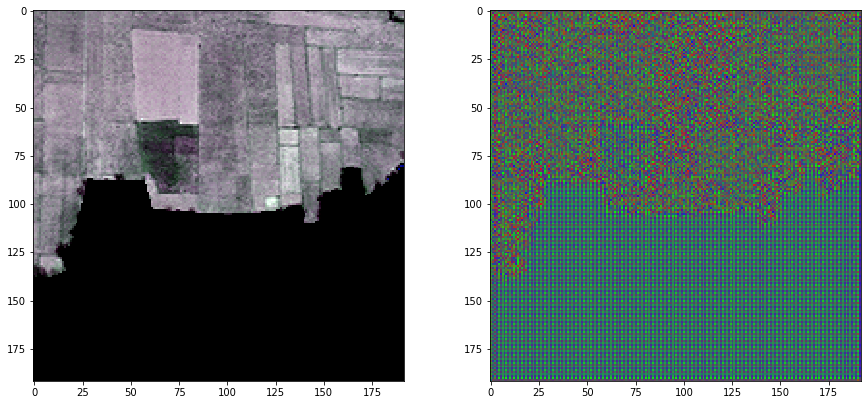

In [0]:
fig=plt.figure(figsize=(15, 15))
fig.add_subplot(2, 2, 1)
plt.imshow(z)
fig.add_subplot(2, 2, 2)
plt.imshow(y)